In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from utilities import *
from crossValidation import *
from features import *

In [2]:
# df1 = pd.read_csv('Analysis/data/full_5m_futures/THETAUSDT_futures_5m_202005_202405.csv', usecols=['Time', 'Close'],memory_map=True)
# df2 = pd.read_csv('Analysis/data/full_5m_spot/TFUELUSDT_spot_5m_202201_202404.csv',  usecols=['Time', 'Close'],memory_map=True)

df1 = pd.read_csv('Analysis/data/full_5m_futures/VETUSDT_futures_5m_202002_202405.csv', usecols=['Time', 'Close'],memory_map=True)
df2 = pd.read_csv('Analysis/data/full_5m_spot/VTHOUSDT_spot_5m_202201_202404.csv',  usecols=['Time', 'Close'],memory_map=True)

df1.Time = pd.to_datetime(df1.Time, unit='ms')
df2.Time = pd.to_datetime(df2.Time, unit='ms')
df1.set_index('Time', inplace=True)
df2.set_index('Time', inplace=True)

# common_start = pd.to_datetime("2022-01-01")
# common_end =None# pd.to_datetime("2023-12-31")

# df1 = df1.loc[common_start:common_end]
# df2 = df2.loc[common_start:common_end]

intersected_indices = df1.index.intersection(df2.index)
df1 = df1.loc[intersected_indices]
df2 = df2.loc[intersected_indices]

lookback = 200
step = 50
y = getPathMatrix(np.log(df1.Close), df1[lookback:][::step].index, lookback, scale = 1)
x = getPathMatrix(np.log(df2.Close), df2[lookback:][::step].index, lookback, scale = 1)

slope, intercept = vectorized_linear_regression(y.values,x.values)

In [3]:
# beta = pd.Series(slope, index = y.index).expanding().mean()
beta = pd.Series(slope, index = y.index).rolling(2000, min_periods = 100).mean()

In [4]:
beta = pd.Series(index = df1.index, data = beta).bfill().ffill()

<Axes: xlabel='Time'>

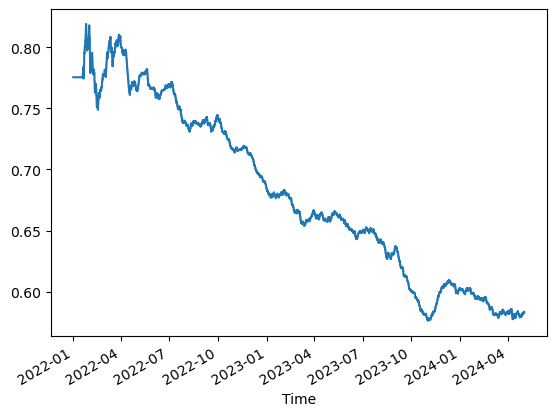

In [5]:
beta.plot()

In [6]:
beta[-1]

0.5836651788907409

In [7]:
# beta = 1

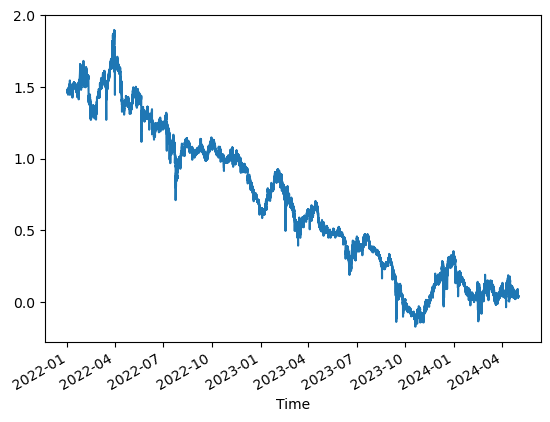

In [8]:

spread = pd.DataFrame()
spread['Close'] = np.log(df1.Close)-np.log(df2.Close)*beta
# spread['Close'] = df1.Close-df2.Close*beta
spread['barID'] = spread.reset_index().index.values
vol1 = spread.Close.ewm(span = 100).std()
vol2 = spread.Close.rolling(100).std()
spread['vol'] = vol1
spread.Close.plot();plt.show()
zscore = getBollinger(spread.Close, lookback= 100, use_log = False)
# zscore = getTrendBlgr(spread.index[100:], spread.Close, 100, 1, use_log = False)

In [9]:
avg_commission

NameError: name 'avg_commission' is not defined

In [54]:
avg_commission

0.00405

In [50]:
# Get Samples (events)
future_commission = 0.0005*2
future_premium = 0.0003*2
spot_commission = 0.001*2 + 0.0005 # interest
spot_premium = 0.002*2 # 들어갈때 한번, 나올때 한번. 
avg_commission = (future_commission+future_premium+spot_commission+spot_premium)/2
minVol = avg_commission*1.5
targetVol = 0.01
start = pd.to_datetime("2021-01-01")
events = getCrossingEvents_dynamicExit(zscore[start:], spread, entry_thres=-2.5, exit_thres1=0, entry_cross='downward', exit_cross1='upward', 
                                       exit_thres2 = None, exit_cross2='downward', mid= 0, minVol = minVol,vol=spread['vol'])

ret1 = get_lrets(events, df1, commission = future_commission+future_premium, side='long', betSize = 1)
ret2 = get_lrets(events, df2, commission = spot_commission+spot_premium, side='short', betSize = beta)
ret = ret1 + ret2
events['ret1'] = ret1
events['ret2'] = ret2
events['ret'] = ret


lev_adj = spread['vol'][ret.index]/targetVol
ret = np.log((np.exp(ret)-1)/lev_adj + 1)
events['ret_adj'] = ret

<Axes: xlabel='Time'>

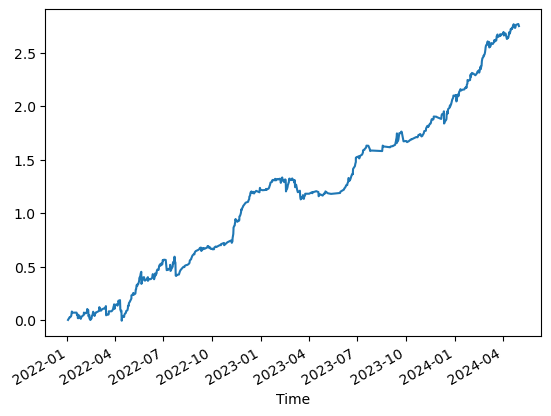

In [51]:
ret.cumsum().plot()

In [57]:
# Get Samples (events)
events = getCrossingEvents_dynamicExit(zscore[start:], spread, entry_thres= 3, exit_thres1=0, entry_cross='upward', exit_cross1='downward', 
                                       exit_thres2 = None, exit_cross2='downward', mid= 0, minVol = minVol,vol=spread['vol'])

ret1 = get_lrets(events, df1, commission = future_commission+future_premium, side='short', betSize = 1)
ret2 = get_lrets(events, df2, commission = spot_commission+spot_premium, side='long', betSize = beta)
ret = ret1 + ret2
events['ret1'] = ret1
events['ret2'] = ret2
events['ret'] = ret


lev_adj = spread['vol'][ret.index]/targetVol
ret = np.log((np.exp(ret)-1)/lev_adj + 1)
events['ret_adj'] = ret

<Axes: xlabel='Time'>

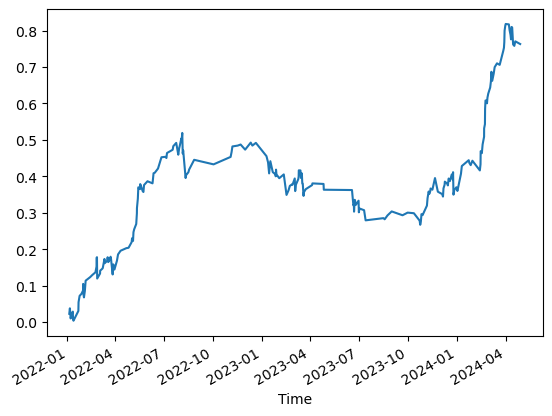

In [58]:
ret.cumsum().plot()